

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          200000    
                                                                 
 bidirectional (Bidirection  (None, 256)               58624     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
Total params: 275592 (1.05 MB)
Trainable params: 275592 (1.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


BiRNN: Average Accuracy = 0.93
120/120 [==============================] - 1s 9ms/s

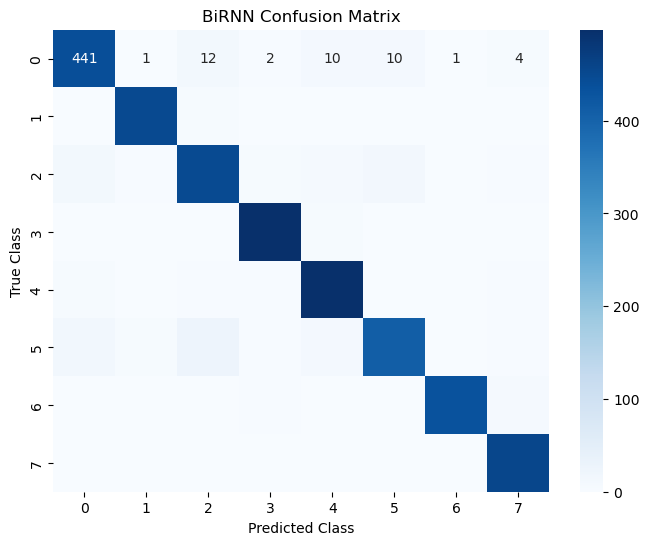

BiRNN Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92       481
           1       0.98      0.99      0.98       457
           2       0.91      0.91      0.91       494
           3       0.97      0.99      0.98       501
           4       0.94      0.98      0.96       510
           5       0.94      0.86      0.90       474
           6       1.00      0.98      0.99       442
           7       0.96      1.00      0.98       456

    accuracy                           0.95      3815
   macro avg       0.95      0.95      0.95      3815
weighted avg       0.95      0.95      0.95      3815



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Bidirectional
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset
df = pd.read_csv('R2_ChatGPt_dataset.csv', encoding='latin1')

# Preprocessing the text data
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in stop_words]
    text = ' '.join(filtered_tokens)
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    text = ' '.join(lemmatized_tokens)
    return text

# Apply the clean_text function to the text column
df['Base_Reviews'] = df['Base_Reviews'].apply(clean_text)

# Define labels dictionary and filter the dataset
y_dict = {'anger': 0, 'confusion': 1, 'disappointment': 2, 'distrust': 3, 'disgust': 4, 'frustration': 5, 'fear': 6, 'sadness': 7}
df = df[df['category'].isin(y_dict.keys())]

# Prepare data for training
X = df['Base_Reviews'].values
y = [y_dict[item] for item in df['category'].values]
num_classes = len(np.unique(y))
y = keras.utils.to_categorical(y, num_classes)

# Tokenization and padding
max_features = 2000
maxlen = 100
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=maxlen)

# Oversampling to balance the dataset
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# BiRNN Model definition
birnn_model = keras.models.Sequential([
    Embedding(max_features, 100, input_length=maxlen),
    Bidirectional(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2)),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.001)
birnn_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
birnn_model.summary()

# K-fold cross-validation
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)
birnn_acc_scores = []
birnn_history_list = []

for train_index, test_index in kf.split(X_resampled):
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]
    birnn_history = birnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, verbose=0)
    birnn_history_list.append(birnn_history)
    birnn_loss, birnn_acc = birnn_model.evaluate(X_test, y_test, verbose=0)
    birnn_acc_scores.append(birnn_acc)

# Output average accuracy
avg_birnn_acc = np.mean(birnn_acc_scores)
print("BiRNN: Average Accuracy = {:.2f}".format(avg_birnn_acc))

# Generate and visualize the confusion matrix
birnn_pred = np.argmax(birnn_model.predict(X_test), axis=-1)
birnn_cm = confusion_matrix(np.argmax(y_test, axis=-1), birnn_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(birnn_cm, annot=True, fmt='d', cmap='Blues')
plt.title('BiRNN Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Classification report
birnn_report = classification_report(np.argmax(y_test, axis=-1), birnn_pred)
print("BiRNN Classification Report:\n", birnn_report)
